In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import random

# synthetic data 불러오기

In [2]:
a1 = open('a1.txt')
file = a1.readlines()

p = re.compile('\d+')

data = []

for line in file:
    x, y = p.findall(line)
    data.append([int(x),int(y)])
    
data = np.array(data)

## data visualization

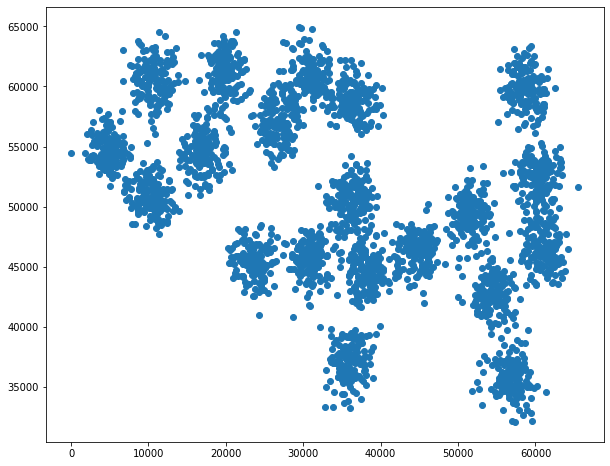

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data[:,0],data[:,1])

## histogram

Text(0, 0.5, 'frequency')

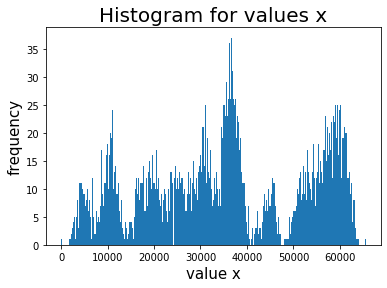

In [4]:
x_hist = plt.hist(data[:,0], bins=300)
plt.title('Histogram for values x', size=20)
plt.xlabel('value x',size=15)
plt.ylabel('frequency', size=15)

Text(0, 0.5, 'frequency')

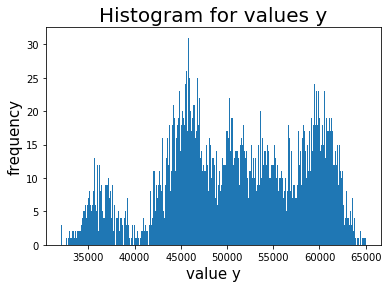

In [5]:
y_hist = plt.hist(data[:,1], bins=300)
plt.title('Histogram for values y', size=20)
plt.xlabel('value y',size=15)
plt.ylabel('frequency', size=15)

# K-means algorithm

In [6]:
import copy
import random 

class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=800, centroids=None):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.dist_l = []
        self.centroids = centroids
        if self.centroids is not None:
            self.k = len(centroids)
        get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
        self.color = get_colors(100)
        
    def fit(self, data):
        self.dist_l = []
        
        self.data = data

        if self.centroids is None :
            self.centroids = {k:v for k,v in enumerate(np.array(random.sample(list(data),self.k)))}

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > self.tol:
#                     print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
                    optimized = False
    
            self.dist_l.append(self.calcul_dist())
        
            if optimized:
                break

    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification
    
    def calcul_dist(self):
        tot_dist = 0
        for key,val in self.classifications.items():
            for p in val:
                dist = np.linalg.norm(self.centroids[key]-p)
                tot_dist += dist
        return tot_dist
    
    def get_farthest_data(self):
        max_dist = 0
        max_dist_p = ()
        for p in self.data:
            sub_min_dist = 10e10
            for c in self.centroids.values():
                if sub_min_dist > np.linalg.norm(c - p):
                    sub_min_dist = np.linalg.norm(c - p)
            if max_dist < sub_min_dist:
                max_dist = sub_min_dist
                max_dist_p = p
        return max_dist_p
                
    def add_centroid(self, p):
        self.centroids[self.k] = p
        self.k += 1
        
    def draw_plot(self, att1, att2):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 8))
        for k in self.classifications.keys():
            x_l = np.array(self.classifications[k])[:,att1]
            y_l = np.array(self.classifications[k])[:,att2]
            plt.scatter(x_l,y_l)
            plt.scatter(np.array(self.centroids[k])[att1], np.array(self.centroids[k])[att2], color='black')

        

# Random initial point (k=20)

In [8]:
random_model = K_Means(k = 20)

random_model.fit(data)


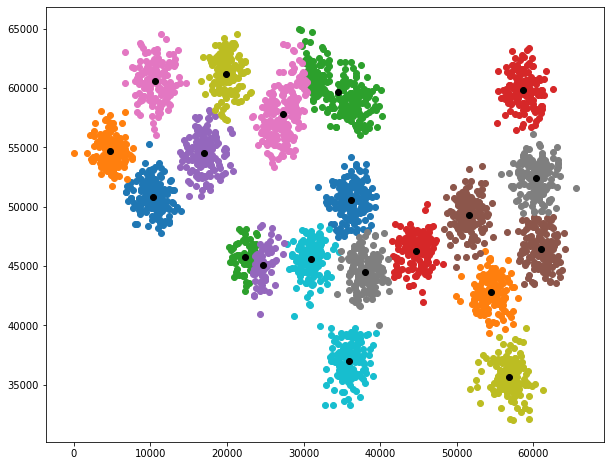

In [9]:
random_model.draw_plot(0,1)


# k-means ++

In [10]:
def get_init_centroids(k, data):
    init_centroids = {0:random.choice(data)}

    while len(init_centroids) < k:
        max_dist_p = 0
        max_dist = 0
        for p in data:
            min_dist_c_idx = 0
            min_dist_c = 10e10
            for c_idx,c  in init_centroids.items():
                if min_dist_c > np.linalg.norm(c - p):
                    min_dist_c_idx = c_idx
                    min_dist_c = np.linalg.norm(c - p)
            if max_dist < min_dist_c:
                max_dist = min_dist_c
                max_dist_p = p

        init_centroids[len(init_centroids)] = max_dist_p
    return init_centroids



In [18]:
init_centroids = get_init_centroids(20, data)



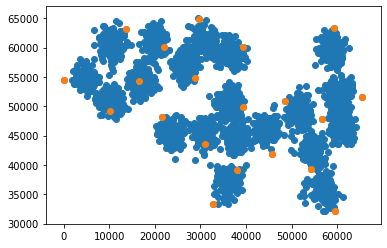

In [19]:
plt.scatter(data[:,0],data[:,1])
plt.scatter([x for x,y in init_centroids.values()],[y for x,y in init_centroids.values()])



In [20]:
k_pp_model = K_Means(centroids=init_centroids)

k_pp_model.fit(data)



/Users/hyunwoo/anaconda3/envs/optlab/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


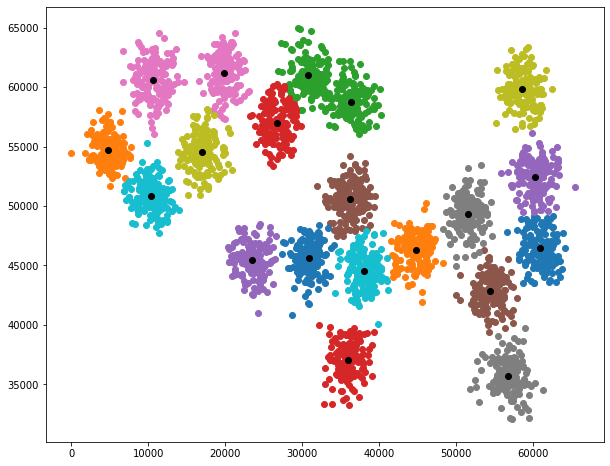

In [21]:
k_pp_model.draw_plot(0,1)



# Cell Division Algorithm based on K-means

하나씩 늘리되, 일정 비율이상 좋아지지 않으면 그만둔다.
하나씩 늘리는 방법은 클러스터와 가장 먼 데이터에 새로운 initial point을 두는 것이다.

In [22]:
def check_reduced_ratio(model, p, threshold=0.2):
    new_model = copy.deepcopy(model)
    new_model.add_centroid(p)

    new_model.fit(model.data)

    if 1-(new_model.dist_l[-1]/model.dist_l[-1]) > threshold:
        return new_model, True
    else:
        return new_model, False

In [23]:
def cell_division(X, threshold=0.1, tolerance=2):
    model = K_Means()
    model.fit(X)
    penalty = 0
    while True:
#         prev_tot_dist = model.dist_l[-1]
#         print(len(model.centroids))
        new_init_p = model.get_farthest_data()
        
        new_model, check_result = check_reduced_ratio(model, new_init_p, threshold)
        
        if check_result:
            model = new_model
        else:
            penalty += 1
            
            if penalty >= tolerance:
                break
            else:
                model = new_model
            
    return model


In [28]:
auto_k = cell_division(data, threshold=0.15, tolerance=1)

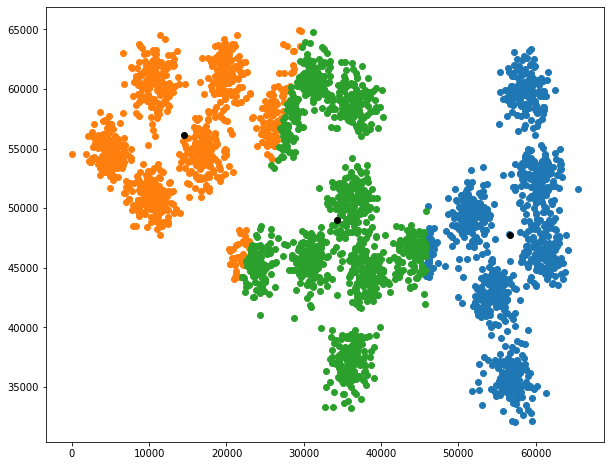

In [29]:
auto_k.draw_plot(0,1)

In [30]:
%%timeit
result = cell_division(data, threshold=0.03, tolerance=3)

/Users/hyunwoo/anaconda3/envs/optlab/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


1min 3s ± 5.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Elbow method with Scikit learn k-means

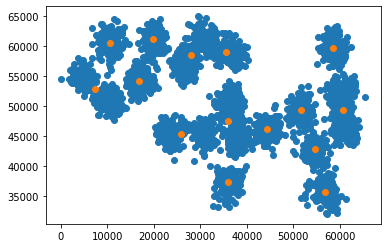

In [47]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=15, random_state=0).fit(data)
sk_centroids = kmeans.cluster_centers_

plt.scatter([x for x,y in data],[y for x,y in data])
plt.scatter([x for x,y in sk_centroids], [y for x,y in sk_centroids])

In [50]:
elbow_l = []
elbow_l2 = []

for i in range(1,50):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
    elbow_l2.append(kmeans.inertia_)
     
    classified = {i:[] for i in range(kmeans.n_clusters)}
    
    for idx,val in enumerate(kmeans.labels_):
        classified[val].append(idx)
    
    tot_dist = 0
    for key,val in classified.items():
        for p in val:
            dist = np.linalg.norm(kmeans.cluster_centers_[key] - data[p])
            tot_dist += dist
    elbow_l.append(tot_dist)

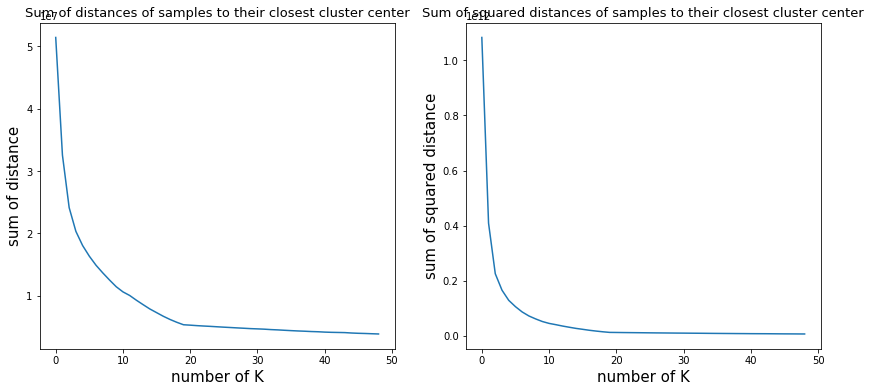

In [51]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((14,6))

axs[0].set_title('Sum of distances of samples to their closest cluster center', size=13)
axs[0].set_ylabel('sum of distance',size=15)
axs[0].set_xlabel('number of K', size=15)
axs[0].plot(elbow_l)

axs[1].set_ylabel('sum of squared distance',size=15)
axs[1].set_xlabel('number of K', size=15)
axs[1].set_title('Sum of squared distances of samples to their closest cluster center', size=13)
axs[1].plot(elbow_l2)

In [1056]:
# 10~15 will be selected by elbow method

# Test with  iris data


In [52]:
from sklearn import datasets
import itertools

iris = datasets.load_iris()
comb_l = list(itertools.combinations(list(range(len(iris['data'][0]))), 2))

X = iris.data
# X = X.astype(np.int64)


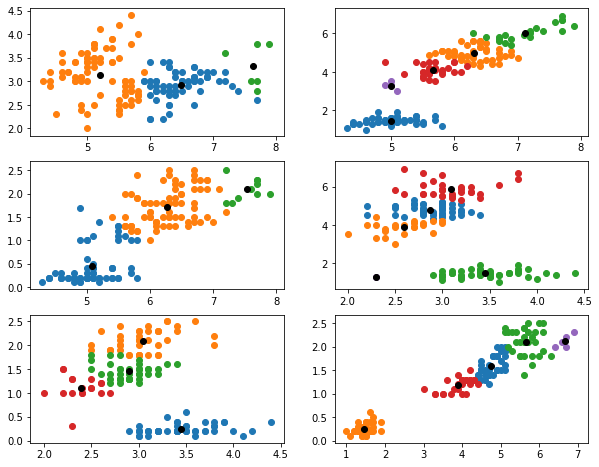

In [53]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches((10,8))

fig_num = 0
for comb in comb_l:
    slctd_X = X[:,comb]
    
    selctd_result = cell_division(slctd_X, threshold=0.15, tolerance=2)
    
    for k in selctd_result.classifications.keys():
        x_l = np.array(selctd_result.classifications[k])[:,0]
        y_l = np.array(selctd_result.classifications[k])[:,1]
        axs[fig_num//2, fig_num%2].scatter(x_l,y_l)
        axs[fig_num//2, fig_num%2].scatter(np.array(selctd_result.centroids[k])[0], np.array(selctd_result.centroids[k])[1], color='black')
    
    fig_num += 1

## iris data 에 대한 다차원 클러스터링

In [56]:
multi_d_result = cell_division(X, threshold=0.15, tolerance=0)

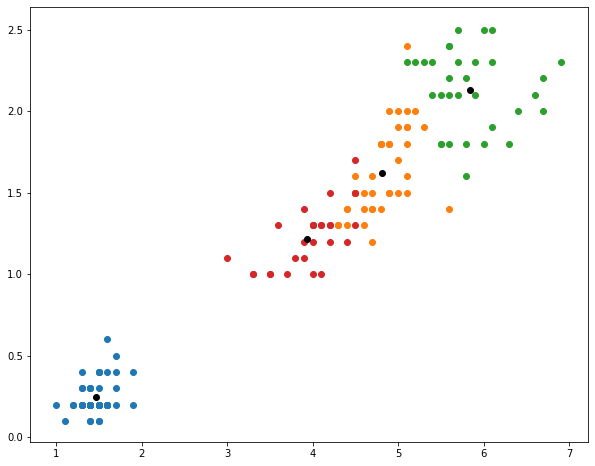

In [57]:
multi_d_result.draw_plot(2,3)

# 실험

## 개수 늘리면서 실험

3000, 5250, 7500

속도, 성능

## parameter 변화시키면서 실험

threshold : 0.05, 0.1, 0.15  
permissible penalty : 1, 2, 3

속도, 성능

In [60]:
import datetime

file_names = ['a1.txt', 'a2.txt', 'a3.txt']
data_dic = {}
for f in file_names:
    a1 = open(f)
    file = a1.readlines()
    p = re.compile('\d+')
    data = []
    for line in file:
        x, y = p.findall(line)
        data.append([int(x),int(y)])
    data = np.array(data)
    data_dic[f] = data

params = {'threshold' : [0.01, 0.03, 0.05, 0.1, 0.15],
          'tolerance' : [0,1,2,3,4,5]}

result = {f:{t:{p:{} for p in params['tolerance']} for t in params['threshold']} for f in file_names}

for t in params['threshold']:
    for p in params['tolerance']:
        for f,d in data_dic.items():
#             print('threshold : ', t, ' tolerance : ', p)
            start_time = datetime.datetime.now()
            model = cell_division(d, threshold=t, tolerance=p)
            running_time = datetime.datetime.now() - start_time
            result[f][t][p]['model'] = model
            result[f][t][p]['time'] = running_time

    

In [321]:
import pickle

with open('result_3.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [335]:
with open('result_3.pickle', 'rb') as handle:
    pickle_result_3 = pickle.load(handle)

0:00:46.212175


20

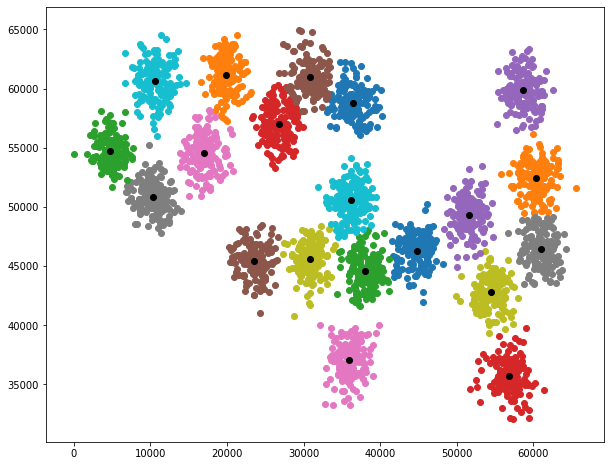

In [390]:
pickle_result_3['a1.txt'][0.01][1]['model'].draw_plot(0,1)
print(pickle_result_3['a1.txt'][0.01][1]['time'])
len(pickle_result_3['a1.txt'][0.01][1]['model'].centroids)

0:03:56.603167


35

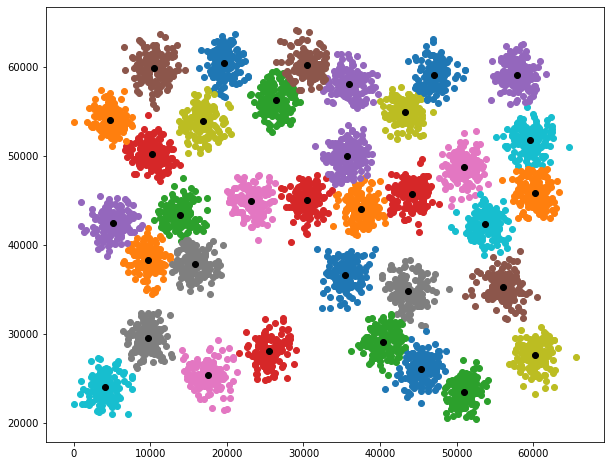

In [389]:
pickle_result_3['a2.txt'][0.01][1]['model'].draw_plot(0,1)
print(pickle_result_3['a2.txt'][0.01][1]['time'])
len(pickle_result_3['a2.txt'][0.01][1]['model'].centroids)

27
0:05:08.297685


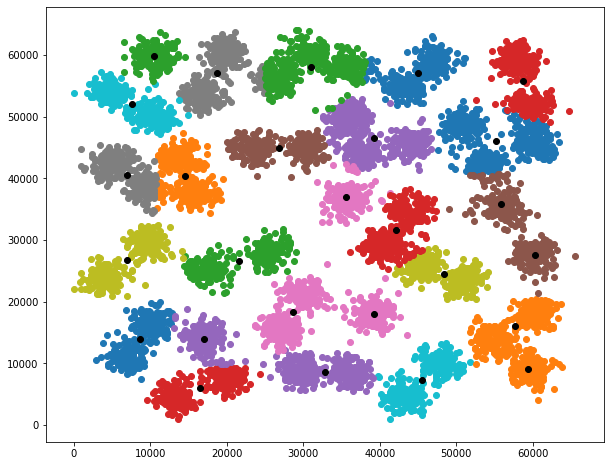

In [391]:
pickle_result_3['a3.txt'][0.01][1]['model'].draw_plot(0,1)
print(len(pickle_result_3['a3.txt'][0.01][1]['model'].centroids))
print(pickle_result_3['a3.txt'][0.01][1]['time'])

## 단순히 k를 변화시키면서 실험

elbow method 이용, 속도 성능

In [322]:
file_names = ['a1.txt', 'a2.txt', 'a3.txt']
max_iter = [30, 40, 60]

elbow_result = {f:{} for f in file_names}

data_dic = {}
for f in file_names:
    a1 = open(f)
    file = a1.readlines()
    p = re.compile('\d+')
    data = []
    for line in file:
        x, y = p.findall(line)
        data.append([int(x),int(y)])
    data = np.array(data)
    data_dic[f] = data
    
for idx,f in enumerate(file_names):
    tot_dist_l = []
    start_time = datetime.datetime.now()
    for k in range(1,max_iter[idx]+1):
        k_model = K_Means(k)
        k_model.fit(data_dic[f])
        tot_dist = k_model.calcul_dist()
        tot_dist_l.append(k_model.calcul_dist())
    running_time = datetime.datetime.now() - start_time
    
    elbow_result[f]['tot_dist_l'] = tot_dist_l
    elbow_result[f]['time'] = running_time
    

/Users/hyunwoo/anaconda3/envs/optlab/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


In [324]:
import pickle

with open('elbow_result.pickle', 'wb') as handle:
    pickle.dump(elbow_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

# elbow_result

## a1.txt data

datetime.timedelta(seconds=201, microseconds=803914)

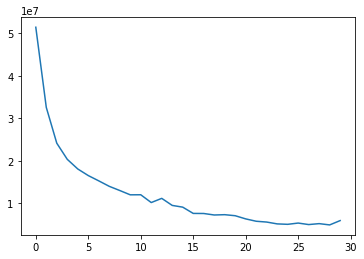

In [380]:
plt.plot(elbow_result['a1.txt']['tot_dist_l'])
elbow_result['a1.txt']['time']

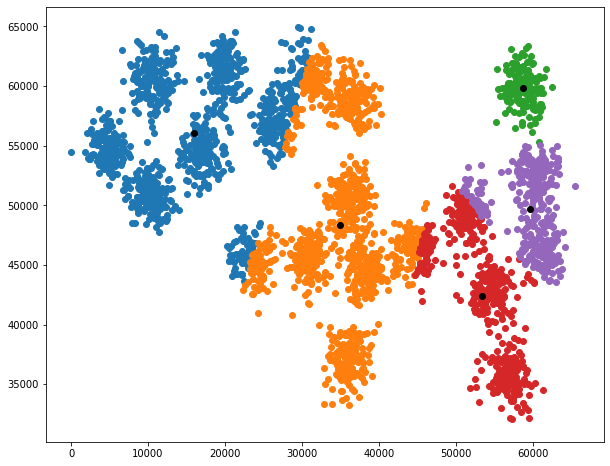

In [381]:
k_model = K_Means(5)
k_model.fit(data_dic['a1.txt'])
k_model.draw_plot(0,1)

## a2.txt data

datetime.timedelta(seconds=690, microseconds=399860)

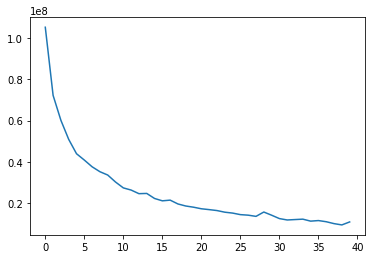

In [382]:
plt.plot(elbow_result['a2.txt']['tot_dist_l'])
elbow_result['a2.txt']['time']

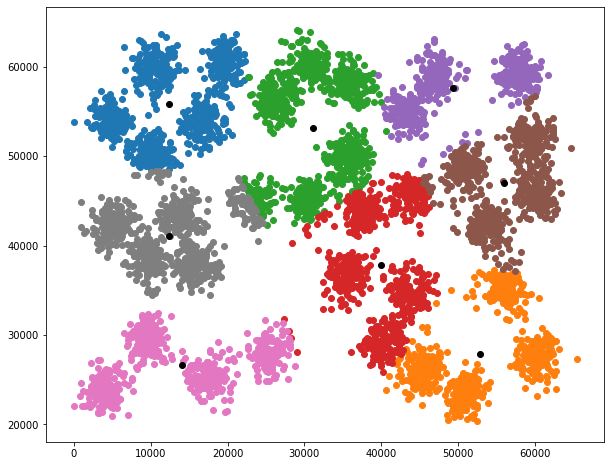

In [383]:
k_model = K_Means(8)
k_model.fit(data_dic['a2.txt'])
k_model.draw_plot(0,1)

## a3.txt data

datetime.timedelta(seconds=3019, microseconds=745464)

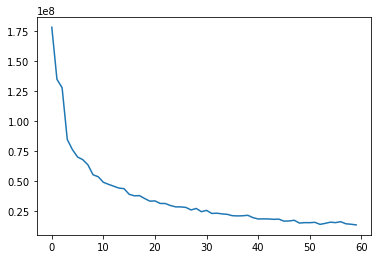

In [386]:
plt.plot(elbow_result['a3.txt']['tot_dist_l'])
elbow_result['a3.txt']['time']

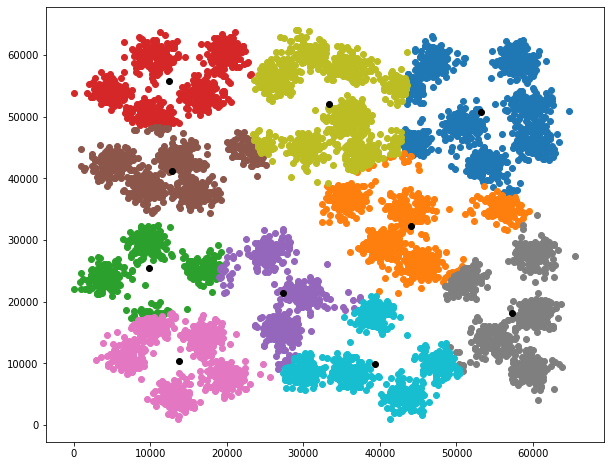

In [388]:
k_model = K_Means(10)
k_model.fit(data_dic['a3.txt'])
k_model.draw_plot(0,1)

# 현실 데이터

Finland

In [405]:
a1 = open('Finland.txt')
file = a1.readlines()

p = re.compile('\d+')

data = []

for line in file:
    x, y = p.findall(line)
    data.append([int(x),int(y)])
    
data = np.array(data)

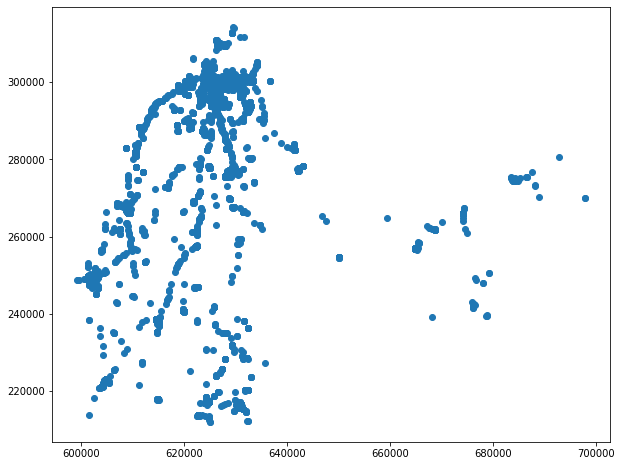

In [413]:
plt.figure(figsize=(10, 8))
plt.scatter(data[:,0],data[:,1])

In [418]:
finland_result = auto_k_means(data, threshold=0.1, tolerance=0)

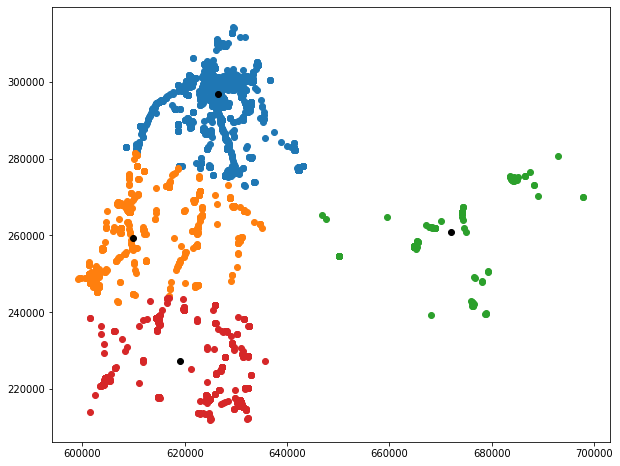

In [419]:
finland_result.draw_plot(0,1)

In [426]:
finland_result = auto_k_means(data, threshold=0.1, tolerance=2)

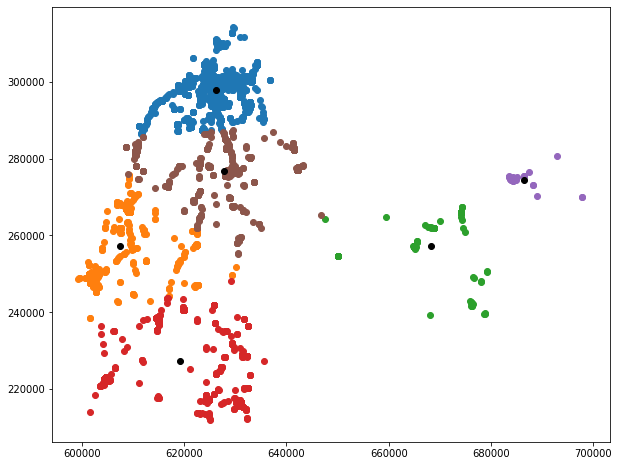

In [427]:
finland_result.draw_plot(0,1)

## customer

In [10]:
import pandas as pd
customer = pd.read_csv('customer.csv')



In [11]:
customer

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


(array([18.,  6., 12., 10., 12., 16., 14., 24., 12., 18., 22., 14.,  2.,
         6.,  6.,  0.,  2.,  2.,  2.,  2.]),
 array([ 15. ,  21.1,  27.2,  33.3,  39.4,  45.5,  51.6,  57.7,  63.8,
         69.9,  76. ,  82.1,  88.2,  94.3, 100.4, 106.5, 112.6, 118.7,
        124.8, 130.9, 137. ]),
 <a list of 20 Patch objects>)

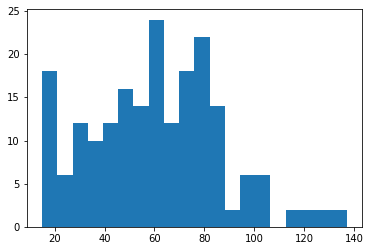

In [12]:
plt.hist(customer.iloc[:,3],bins=20)

(array([ 9.,  7., 12.,  8.,  3.,  7.,  9.,  8., 17., 18., 17., 20.,  6.,
         5., 11., 13.,  5.,  9., 10.,  6.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <a list of 20 Patch objects>)

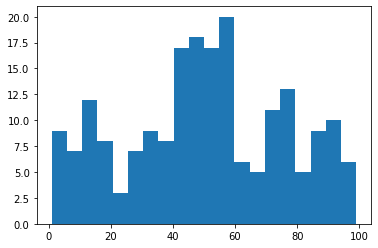

In [13]:
plt.hist(customer.iloc[:,4],bins=20)

(array([17., 14.,  7., 12., 12., 22., 20.,  9., 11.,  5.,  8., 18.,  7.,
         8.,  2.,  8.,  3.,  3.,  8.,  6.]),
 array([18. , 20.6, 23.2, 25.8, 28.4, 31. , 33.6, 36.2, 38.8, 41.4, 44. ,
        46.6, 49.2, 51.8, 54.4, 57. , 59.6, 62.2, 64.8, 67.4, 70. ]),
 <a list of 20 Patch objects>)

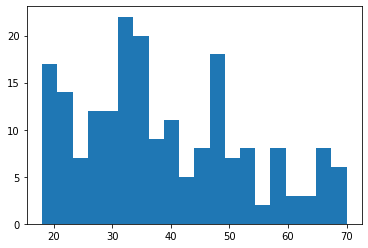

In [14]:
plt.hist(customer.iloc[:,2],bins=20)

(array([ 88.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 112.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

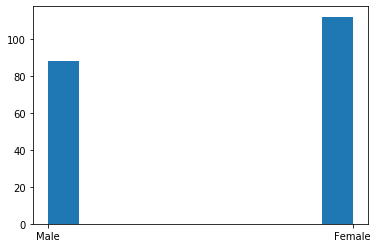

In [15]:
plt.hist(customer.iloc[:,1])

In [53]:
data = []
for row in customer.iterrows():
    row_li = list(row[1])
    
    if row_li[1] == 'Male':
        row_li[1] = 1
    else:
        row_li[1] = 0
    data.append(row_li[1:])
data = np.array(data)



In [77]:
customer_result = auto_k_means(data, threshold=0.05, tolerance=1)



/Users/hyunwoo/anaconda3/envs/optlab/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


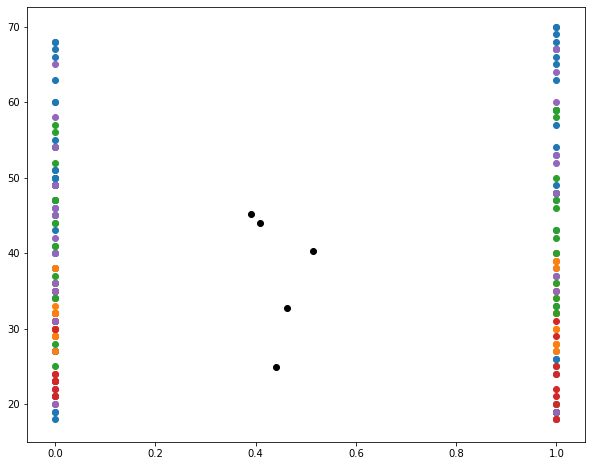

In [78]:
customer_result.draw_plot(0,1)



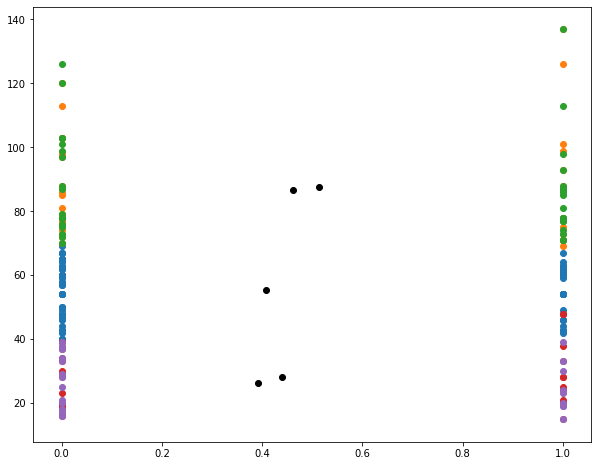

In [79]:
customer_result.draw_plot(0,2)



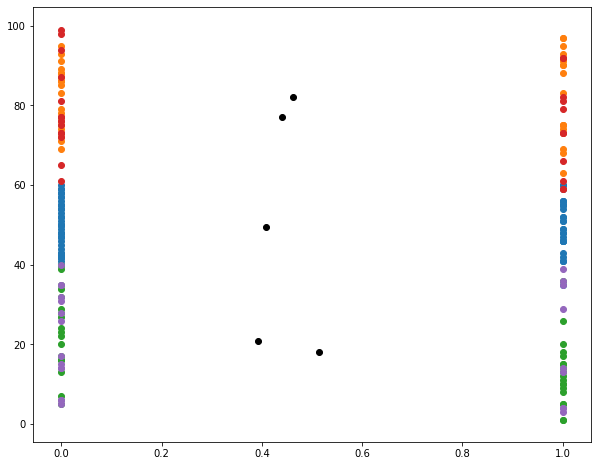

In [80]:
customer_result.draw_plot(0,3)



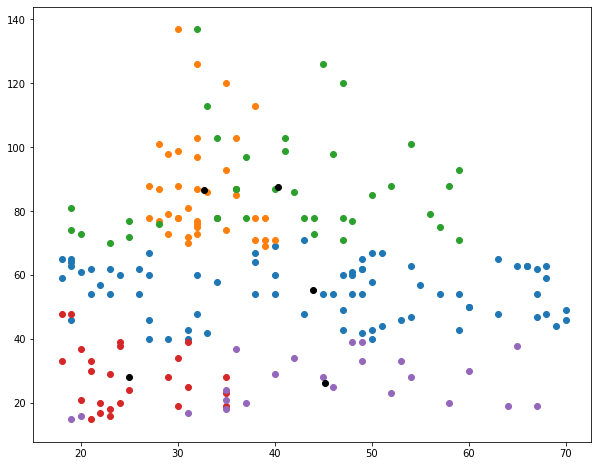

In [81]:
customer_result.draw_plot(1,2)



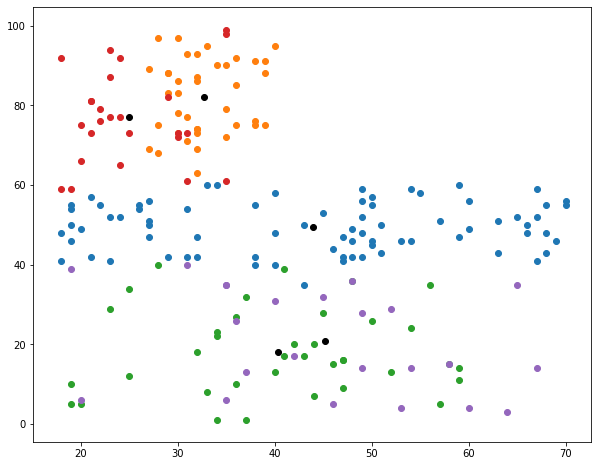

In [82]:
customer_result.draw_plot(1,3)



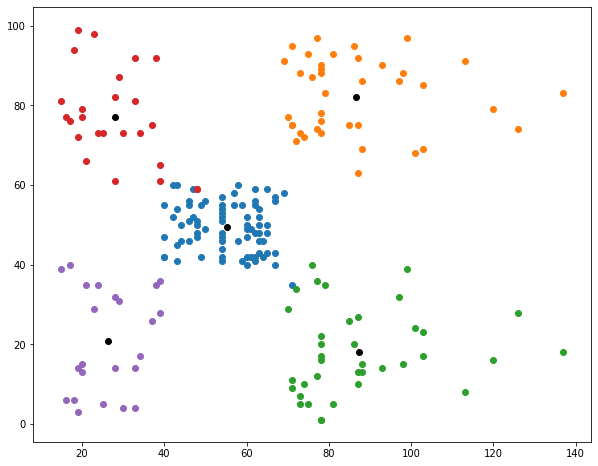

In [83]:
customer_result.draw_plot(2,3)

